In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training, development, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Transpose for consistency with previous code
X_train = X_train.T
X_dev = X_dev.T
X_test = X_test.T

In [3]:
def init_params():
    W1 = np.random.rand(128, 64) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(64, 128) - 0.5
    b2 = np.random.rand(64, 1) - 0.5
    W3 = np.random.rand(10, 64) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def dropout(A, keep_prob):
    D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
    A = np.multiply(A, D)
    A = A / keep_prob
    return A

def forward_prop(W1, b1, W2, b2, W3, b3, X, keep_prob):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    A1 = dropout(A1, keep_prob)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    A2 = dropout(A2, keep_prob)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

In [4]:
def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, keep_prob):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / X.shape[1] * dZ3.dot(A2.T)
    db3 = 1 / X.shape[1] * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = W3.T.dot(dZ3)
    dA2 = dropout(dA2, keep_prob)
    dZ2 = dA2 * ReLU_deriv(Z2)
    dW2 = 1 / X.shape[1] * dZ2.dot(A1.T)
    db2 = 1 / X.shape[1] * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = W2.T.dot(dZ2)
    dA1 = dropout(dA1, keep_prob)
    dZ1 = dA1 * ReLU_deriv(Z1)
    dW1 = 1 / X.shape[1] * dZ1.dot(X.T)
    db1 = 1 / X.shape[1] * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3

In [5]:
def update_params_adam(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3, t, alpha, beta1, beta2, epsilon):
    mW1 = beta1 * mW1 + (1 - beta1) * dW1
    mb1 = beta1 * mb1 + (1 - beta1) * db1
    mW2 = beta1 * mW2 + (1 - beta1) * dW2
    mb2 = beta1 * mb2 + (1 - beta1) * db2
    mW3 = beta1 * mW3 + (1 - beta1) * dW3
    mb3 = beta1 * mb3 + (1 - beta1) * db3
    
    vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
    vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
    vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
    vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)
    vW3 = beta2 * vW3 + (1 - beta2) * (dW3 ** 2)
    vb3 = beta2 * vb3 + (1 - beta2) * (db3 ** 2)
    
    mW1_corr = mW1 / (1 - beta1 ** t)
    mb1_corr = mb1 / (1 - beta1 ** t)
    mW2_corr = mW2 / (1 - beta1 ** t)
    mb2_corr = mb2 / (1 - beta1 ** t)
    mW3_corr = mW3 / (1 - beta1 ** t)
    mb3_corr = mb3 / (1 - beta1 ** t)
    
    vW1_corr = vW1 / (1 - beta2 ** t)
    vb1_corr = vb1 / (1 - beta2 ** t)
    vW2_corr = vW2 / (1 - beta2 ** t)
    vb2_corr = vb2 / (1 - beta2 ** t)
    vW3_corr = vW3 / (1 - beta2 ** t)
    vb3_corr = vb3 / (1 - beta2 ** t)
    
    W1 = W1 - alpha * (mW1_corr / (np.sqrt(vW1_corr) + epsilon))
    b1 = b1 - alpha * (mb1_corr / (np.sqrt(vb1_corr) + epsilon))
    W2 = W2 - alpha * (mW2_corr / (np.sqrt(vW2_corr) + epsilon))
    b2 = b2 - alpha * (mb2_corr / (np.sqrt(vb2_corr) + epsilon))
    W3 = W3 - alpha * (mW3_corr / (np.sqrt(vW3_corr) + epsilon))
    b3 = b3 - alpha * (mb3_corr / (np.sqrt(vb3_corr) + epsilon))
    
    return W1, b1, W2, b2, W3, b3, mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3

def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent_adam(X, Y, alpha, iterations, keep_prob, beta1, beta2, epsilon):
    W1, b1, W2, b2, W3, b3 = init_params()
    mW1, mb1, mW2, mb2, mW3, mb3 = 0, 0, 0, 0, 0, 0
    vW1, vb1, vW2, vb2, vW3, vb3 = 0, 0, 0, 0, 0, 0
    for i in range(1, iterations + 1):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, keep_prob)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y, keep_prob)
        W1, b1, W2, b2, W3, b3, mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3 = update_params_adam(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, mW1, mb1, mW2, mb2, mW3, mb3, vW1, vb1, vW2, vb2, vW3, vb3, i, alpha, beta1, beta2, epsilon)
        if i % 10 == 0:
            predictions = get_predictions(A3)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration {i}: {accuracy * 100}%")
    return W1, b1, W2, b2, W3, b3

In [6]:
# Perform gradient descent with Adam optimizer
keep_prob = 0.8  # Dropout keep probability
alpha = 0.001  # Learning rate
iterations = 1000  # Number of iterations
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [7]:
W1, b1, W2, b2, W3, b3 = gradient_descent_adam(X_train, Y_train, alpha, iterations, keep_prob, beta1, beta2, epsilon)

Iteration 10: 11.781076066790352%
Iteration 20: 26.808905380333954%
Iteration 30: 42.67161410018553%
Iteration 40: 56.86456400742115%
Iteration 50: 63.07977736549165%
Iteration 60: 68.73840445269018%
Iteration 70: 72.63450834879406%
Iteration 80: 76.1595547309833%
Iteration 90: 79.22077922077922%
Iteration 100: 79.12801484230056%
Iteration 110: 83.30241187384044%
Iteration 120: 83.85899814471243%
Iteration 130: 83.85899814471243%
Iteration 140: 86.73469387755102%
Iteration 150: 85.62152133580705%
Iteration 160: 88.21892393320965%
Iteration 170: 87.291280148423%
Iteration 180: 89.33209647495362%
Iteration 190: 88.21892393320965%
Iteration 200: 89.51762523191094%
Iteration 210: 89.6103896103896%
Iteration 220: 90.9090909090909%
Iteration 230: 91.55844155844156%
Iteration 240: 90.9090909090909%
Iteration 250: 93.41372912801485%
Iteration 260: 93.32096474953617%
Iteration 270: 93.22820037105751%
Iteration 280: 93.87755102040816%
Iteration 290: 92.94990723562152%
Iteration 300: 94.248608534

In [8]:
# Evaluate on the development set
_, _, _, _, _, A3_dev = forward_prop(W1, b1, W2, b2, W3, b3, X_dev, keep_prob)
predictions_dev = get_predictions(A3_dev)
accuracy_dev = get_accuracy(predictions_dev, Y_dev)

print("Development set accuracy:", accuracy_dev)

Development set accuracy: 0.9442896935933147


In [9]:
# Define make_predictions and test_prediction functions
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X, 1.0)  # No dropout during prediction
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_test[:, index, None]
    prediction = make_predictions(X_test[:, index, None], W1, b1, W2, b2, W3, b3)
    label = Y_test[index]
    
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((8, 8)) * 255  # Reshape to 8x8 (since we're using the digits dataset)
    current_image = zoom(current_image, (28 / 8, 28 / 8))  # Resize to 28x28
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


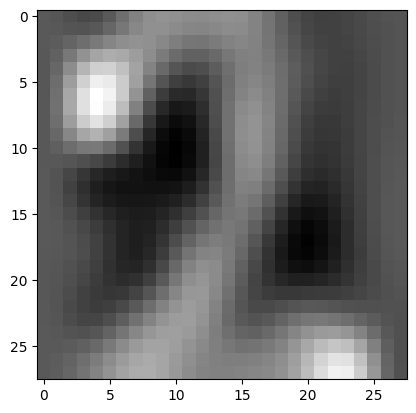

Prediction:  [6]
Label:  6


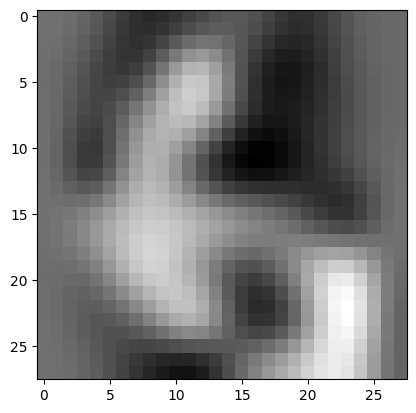

Prediction:  [5]
Label:  5


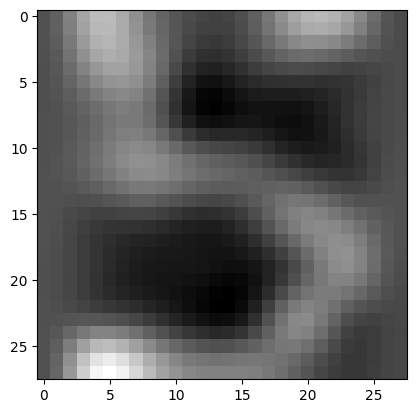

Prediction:  [8]
Label:  8


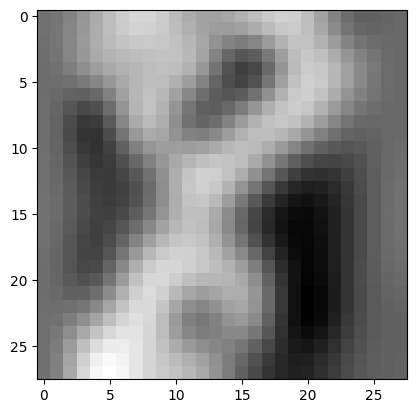

In [12]:
# Test a few predictions
test_prediction(0, W1, b1, W2, b2, W3, b3)
test_prediction(2, W1, b1, W2, b2, W3, b3)
test_prediction(6, W1, b1, W2, b2, W3, b3)
test_prediction(9, W1, b1, W2, b2, W3, b3)

In [11]:
# Evaluate on the test set
_, _, _, _, _, A3_test = forward_prop(W1, b1, W2, b2, W3, b3, X_test, keep_prob)
predictions_test = get_predictions(A3_test)
accuracy_test = get_accuracy(predictions_test, Y_test)

print("Test set accuracy:", accuracy_test)

Test set accuracy: 0.9305555555555556
